In [22]:
!spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ----------------- ---------------------- 5.8/12.9 MB 39.3 MB/s eta 0:00:01
     --------------------------------------- 12.9/12.9 MB 40.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [23]:
# !pip install spacy

In [24]:
import re
import csv
import json
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import spacy
from spellchecker import SpellChecker
spell = SpellChecker(language='es')
nlp = spacy.load('es_core_news_sm') # For lemmatizing the words

In [25]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

In [26]:
bills = pd.read_csv('./Clean/bills.csv')
bills.shape

(742, 10)

In [27]:
bills.head(10)

,Unnamed: 0,number,title,Autores,type_bill,year,period,state_bill,authors_positions,authors_count
0,0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.666667,3.0
1,2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado,1.000000,1.0
2,3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.500000,8.0
3,4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado,0.000000,1.0
4,5,PL309-22,PL 309-23 Corridas de Toros,"['Ministro de Cultura', 'Dr. JORGE IGNACIO ZOR...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.930233,43.0
5,6,PL308-22,PL 308-23 Ley Cero,"['KARINA ESPINOSA OLIVER', 'OSCAR MAURICIO GIR...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.054054,37.0
6,7,PL306-22,PL 306-23 Contraloría,"['JUAN FELIPE LEMOS URIBE', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.000000,23.0
7,8,PL305-22,PL 305-23 Administraciones Distritales,"['JORGE ELIECER TAMAYO MARULANDA', 'JOSÉ ELIÉC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.380952,21.0
8,9,PL304-22,PL 304-23 Medalla Edwin KemmererDescargar,"['JORGE BENEDETTI MARTELO', 'ROY BARRERAS MONT...",Proyecto de ley,2022-2023,2022 - 2026,ley,-0.379310,29.0
9,10,PL302-22,PL 302-23 Contratación,"['HONORIO MIGUEL HENRÍQUEZ PINEDO', 'ENRIQUE C...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-1.000000,14.0


In [28]:
# Read all the txt files in the folder and put them in an array in the order specified
# Returns also only the titles it found
def get_bills_text(bills_path, file_names):
  bills_txt = []
  names_found = []
  for bill in file_names:
    try:
      with open(bills_path + '/' + bill + '_ocr.txt', 'r', encoding="utf8") as f:
        bills_txt.append(f.read())
        names_found.append(bill)
    except FileNotFoundError:
      print(f"File {bill}_ocr.txt not found.")
  return bills_txt, names_found

In [8]:
file_names = bills['title'].values
    # Read all the txt files in the folder and put them in an array in the order specified
texts, bills_found = get_bills_text('./Raw/Bills_txt', file_names)
labels_df = bills[bills['title'].isin(bills_found)].copy()
labels_df.reset_index(drop=True, inplace=True)
print(labels_df.shape, len(texts))

File PL-284S-2023--196C-2022 Honores SalentoDescargar _ocr.txt not found.
File PL-271S-2022 Derecho a la gestion comunitaria del  agua_ocr.txt not found.
File PL-234 Convención interamericana contra toda forma de discriminación e intolerancia_ocr.txt not found.
File PL-231 Servicio público domiciliario esencial de gas natural en nuevas viviendas de interés social VIS y viviendas de interés prioritario VIP_ocr.txt not found.
File PL-225 Trabajador Bananero_ocr.txt not found.
File PL-224 Perros guia_ocr.txt not found.
File PL-223 Participacion de los jovenes_ocr.txt not found.
File PL-206 Divorcio_ocr.txt not found.
File PL-200 Canales de comercializacion para pequeños y medianos productores_ocr.txt not found.
File PL-199 Patrimonio Cultural Encuentro Nacional del Tiple - Envigado_ocr.txt not found.
File PL-189 Honores Jose Maria Cordoba_ocr.txt not found.
File PL-181 Politica de paz de estado_ocr.txt not found.
File PL-090 Protesta social_ocr.txt not found.
File PL 042-23 Hurto_ocr.txt 

In [9]:
texts[4][:500]

'Pe CONGRESO cali DELAREPUÚ, DE COLOMBIA, 4. O Bogotá D.C., 26 de abril de 2023 Doctor GREGORIO ELJAS PACHECO Secretario General Senado de la República Bogotá D.C. REY: RADICACIÓN PROYECTO DE LEY Respetado Señor Secretario General: En nuestra condición de miembros del Congreso de la República y en uso del derecho consagrado en el artículo 150 de la Constitución Política de Colombia, por su digno conducto nos permitimos poner a consideración del Honorable Congreso de la República, el siguiente pro'

In [10]:
def check_word(word):
    return word.lower() not in spell.unknown([word])

In [11]:
def lemmatize_words(text, stop_words):
    words = text.split(' ')
    lemmatized = []
    for word in words:
        if check_word(word) and word not in stop_words:  # Check if the word exists in spanish or is a mistake from OCR or a typo or a stop word
            doc = nlp(word)
            if len(doc) > 0:
                lemmatized.append(doc[0].lemma_)
    return lemmatized

In [12]:
def text_preprocessing(texts, stop_words):
    text_cln = []
    for text in tqdm(texts):
        text = re.sub(r'[\W\d_]+', ' ', text.strip().lower())
        text_cln.append(' '.join(lemmatize_words(text, stop_words)))
        # text_cln.append(text)
    return text_cln

In [29]:
# https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# Get stop words
stop_words = ['artículo', 'ley', 'congreso', 'cámara', 'senado', 'representantes', 'senador', 'senadora', 'ministerio', 'partido', 'político',
              'representante', 'colombia', 'república', 'edificio', 'calle', 'carrera', 'padilla', 'oficina', 'paloma', 'esmeralda',
              'teléfono', 'piso', 'proyecto', 'nacional', 'país', 'html', 'www', 'com', 'co', 'gov', 'público', 'presente', 'parágrafo', 'general', 
              'información', 'congresista', 'página', 'interés', 'objeto', 'aplicar', 'copia', 'medio', 'ministro']
print(len(stop_words))
with open('./Raw/spanish.txt', 'r', encoding="utf8") as f:
    for line in f:
        stop_words.append(line.strip())
response = requests.get('https://raw.githubusercontent.com/Alir3z4/stop-words/refs/heads/master/spanish.txt')
response.raise_for_status()
stop_words += response.text.splitlines()
print(len(stop_words))
# cleaning the names and last names that may appear in the text (congresspeople's names and heads of other entities)
# https://github.com/olea/lemarios/blob/master/nombres-propios-es.txt
# https://github.com/olea/lemarios/blob/master/apellidos-es.txt
response = requests.get('https://raw.githubusercontent.com/olea/lemarios/refs/heads/master/nombres-propios-es.txt')
response.raise_for_status()
stop_words += response.text.splitlines()
print(len(stop_words))
response = requests.get('https://raw.githubusercontent.com/olea/lemarios/refs/heads/master/apellidos-es.txt')
response.raise_for_status() 
stop_words += response.text.splitlines()
len(stop_words)

44
1260
1715


1818

In [14]:
import os
if os.path.isfile("text_cln.pkl"):
    with open("text_cln.pkl", 'rb') as f:
        text_cln = pickle.load(f)
else:
    text_cln = text_preprocessing(texts, stop_words)
len(text_cln)

725

In [15]:
# Save the array to a pickle file
with open("text_cln.pkl", "wb") as f:
    pickle.dump(text_cln, f)

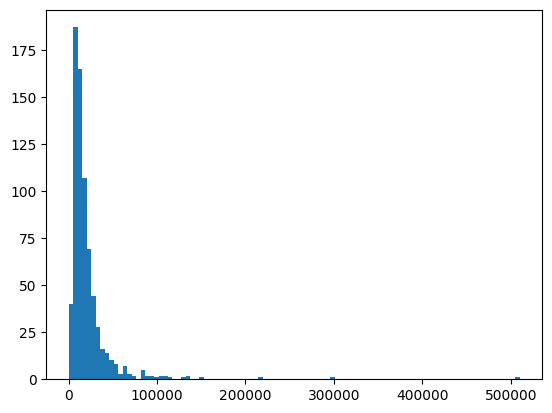

In [16]:
plt.hist([len(doc) for doc in text_cln], bins=100) 
plt.show()

In [17]:
text_cln[29][:500]

'medio reforma cambiar denominación ministerio cultura término economía naranja medio reforma cambiar denominación ministerio cultura término economía naranja objeto presente objeto cambiar denominación ministerio cultura ministerio diverso pueblo colombiano reconocido constitución político ampliar denominación economía naranja ministerio ministerio organismo rector cultura encargado formular coordinar ejecutar vigilar político materia concordancia desarrollo participación ministerio cargo presen'

In [18]:
tfidf_vect = TfidfVectorizer(min_df=0.1, max_df=0.90, stop_words=stop_words, sublinear_tf=False, strip_accents=None)
tfidf = tfidf_vect.fit_transform(text_cln)
tfidf.shape

C:\Users\Daniel Cardenas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aarón', 'abdón', 'abel', 'abelardo', 'abrahán', 'absalón', 'acacio', 'adalberto', 'adela', 'adelaida', 'adolfo', 'adrián', 'adán', 'adón', 'aguilar', 'agustín', 'aitor', 'alba', 'albert', 'alberto', 'albina', 'alejandra', 'alejandro', 'alejo', 'alfonso', 'alfredo', 'alicia', 'alipio', 'almudena', 'alonso', 'amadeo', 'amaro', 'ambrosio', 'amelia', 'amparo', 'ana', 'ananías', 'anastasia', 'anatolio', 'andrea', 'andrés', 'aniano', 'anna', 'anselmo', 'antero', 'antonia', 'antonio', 'aquiles', 'araceli', 'arcadio', 'aresio', 'ariadna', 'arias', 'aristides', 'arnaldo', 'artemio', 'arturo', 'aránzazu', 'ascensión', 'asunción', 'atanasio', 'augusto', 'aurelia', 'aureliano', 'aurelio', 'aurora', 'baldomero', 'balduino', 'baltasar', 'bartolomé', 'basileo', '

(725, 1692)

# K-Means

In [19]:
labels = KMeans(init='k-means++', n_clusters=3, random_state=0, n_init=100).fit_predict(tfidf)

In [20]:
k_range = range(3,30)
inertia = []
silhouette = []

for i in k_range:
    km_i = KMeans(init='k-means++', n_clusters=i, max_iter=100000,
                  random_state=0, n_init=100)
    inertia.append(km_i.fit(tfidf).inertia_)
    silhouette.append(silhouette_score(tfidf, km_i.fit_predict(tfidf), metric='cosine'))


KeyboardInterrupt



In [ ]:
plt.plot(k_range, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Sum of Squared Errors')
plt.show()

In [ ]:
plt.plot(k_range, silhouette)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Score')
plt.show()

In [ ]:
arr = np.array(labels)
unique, counts = np.unique(arr, return_counts=True)

print(dict(zip(unique, counts)))

# LDA

In [30]:
search_params = {
  'n_components': [10, 15, 18, 19, 20, 25, 30],
  'learning_decay': [.5, .7]
}
# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online', random_state=14)

# Try all of the options
gridsearch = GridSearchCV(model, param_grid=search_params, n_jobs=-1, verbose=1)
gridsearch.fit(tfidf)

# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -24382.529417591268


In [31]:
LDA = LatentDirichletAllocation(random_state=14, learning_method='online', learning_decay=gridsearch.best_params_['learning_decay'], 
                                n_components=gridsearch.best_params_['n_components'])

In [32]:
theta = LDA.fit_transform(tfidf)
theta.shape

(725, 10)

In [33]:
beta = LDA.components_
beta.shape

(10, 1692)

In [34]:
topic_saliency = theta.sum(axis=0) / theta.sum()
topic_saliency

array([0.00589597, 0.00589597, 0.00589597, 0.00589597, 0.00589597,
       0.94693628, 0.00589597, 0.00589597, 0.00589597, 0.00589597])

In [35]:
# review top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

In [36]:
features = tfidf_vect.get_feature_names_out()
print_top_words(model=LDA, feature_names = features, n_top_words = 20)

Topic #0: memorio construcción cultura paz nación gobierno cultural derecho colombiano historia decreto consejo tierra conservador constitución histórico pueblo octubre valencia cambio 

Topic #1: sitio social peligro afectado códecir medicina gestión pena utilización legal temprano estructural madre contado capítulo colectivo observar interior patrimonio recuperar 

Topic #2: agropecuario códecir condición compañía protección educación consejo establecer relación número propiedad derecho constitucional sector penal colombiano superior nación social violencia 

Topic #3: sistema servicio salud social garantizar democracia educación médico físico democrático edad prestación persona acceso derecho plataforma relación personal tecnología diagnóstico 

Topic #4: deporte tasa tránsito educación cumplimiento físico vida garantizar derecho construcción beneficio pobreza administración nivel necesario ampliación consecuencia constitucional población social 

Topic #5: derecho social protección

In [ ]:
def plot_top_words(model, feature_names, n_top_words, topic_saliency, title):
    fig, axes = plt.subplots(1, len(topic_saliency), figsize=(30, 15), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        topic_dist = topic / topic.sum()  
        top_features_ind = topic_dist.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic_dist[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}\n({round(topic_saliency[topic_idx]*100, 2)}% of docs)", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
plot_top_words(model=LDA, feature_names = features, topic_saliency=topic_saliency, n_top_words = 20, title='Topics in the bills')

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(LDA, tfidf, tfidf_vect)
vis

In [ ]:
LDA = LatentDirichletAllocation(random_state=14, 
                                learning_method='online', 
                                learning_decay= 0.7,
                                max_iter=10,
                                learning_offset=50.,
                                n_components=7)
theta = LDA.fit_transform(tfidf)
topic_saliency = theta.sum(axis=0) / theta.sum()
topic_saliency

In [ ]:
print_top_words(model=LDA, feature_names = features, n_top_words = 20)

In [ ]:
plot_top_words(model=LDA, feature_names = features, n_top_words = 20, topic_saliency=topic_saliency, title='Topics in the bills')

In [ ]:
from gensim.models import CoherenceModel
import gensim

# Compute coherence score
coherence_model = CoherenceModel(
    topics=[[feature_names[i] for i in lda.components_[j].argsort()[:-10 - 1:-1]] for j in range(lda.n_components)],
    texts=your_tokenized_documents,
    dictionary=gensim.corpora.Dictionary(your_tokenized_documents),
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

In [ ]:
!pip uninstall gensim
!pip install gensim

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

def advanced_lda_diagnostics(documents, min_topics=2, max_topics=15):
    """
    Comprehensive LDA diagnostics to help identify optimal topic configuration
    
    Parameters:
    documents: list of text documents
    min_topics: minimum number of topics to try
    max_topics: maximum number of topics to try
    
    Returns:
    Dictionary with diagnostic information
    """
    # Diagnostic storage
    diagnostics = {
        'topic_coherence': [],
        'topic_saliency': [],
        'perplexity_scores': []
    }
    
    # Create different vectorization strategies
    vectorizers = [
        ('count', CountVectorizer(
            max_features=5000, 
            stop_words=stop_words, 
            max_df=0.95, 
            min_df=2
        )),
        ('tfidf', TfidfVectorizer(
            max_features=5000, 
            stop_words=stop_words, 
            max_df=0.95, 
            min_df=2
        ))
    ]
    
    for vec_name, vectorizer in vectorizers:
        # Create document-term matrix
        doc_term_matrix = vectorizer.fit_transform(documents)
        
        # Track results for this vectorization method
        vec_diagnostics = {
            'topic_saliency': [],
            'perplexity_scores': []
        }
        
        # Try different numbers of topics
        for n_topics in range(min_topics, max_topics + 1):
            # LDA with different configurations
            lda_configs = [
                # Default
                LatentDirichletAllocation(
                    n_components=n_topics, 
                    random_state=42, 
                    max_iter=20
                ),
                # Adjusted alpha (more balanced topics)
                LatentDirichletAllocation(
                    n_components=n_topics, 
                    random_state=42, 
                    max_iter=20,
                    doc_topic_prior=1/n_topics,  # More uniform topic distribution
                    topic_word_prior=1/doc_term_matrix.shape[1]
                )
            ]
            
            for lda_model in lda_configs:
                # Fit LDA
                lda_output = lda_model.fit_transform(doc_term_matrix)
                
                # Calculate topic saliency (max topic probability for each document)
                max_topic_probs = lda_output.max(axis=1)
                saliency = {
                    'mean': max_topic_probs.mean(),
                    'max': max_topic_probs.max(),
                    'std': max_topic_probs.std()
                }
                vec_diagnostics['topic_saliency'].append(saliency)
                
                # Perplexity score
                vec_diagnostics['perplexity_scores'].append(lda_model.perplexity(doc_term_matrix))
        
        # Aggregate results
        diagnostics[f'{vec_name}_topic_saliency'] = vec_diagnostics['topic_saliency']
        diagnostics[f'{vec_name}_perplexity_scores'] = vec_diagnostics['perplexity_scores']
    
    return diagnostics

def visualize_lda_diagnostics(diagnostics):
    """
    Create diagnostic plots to help understand topic distribution
    """
    plt.figure(figsize=(15, 5))
    
    # Saliency plot
    plt.subplot(131)
    saliency_means = [d['mean'] for d in diagnostics['count_topic_saliency']]
    plt.plot(range(2, 16), saliency_means, marker='o')
    plt.title('Mean Topic Saliency')
    plt.xlabel('Number of Topics')
    plt.ylabel('Mean Max Topic Probability')
    
    # Perplexity plot
    plt.subplot(132)
    plt.plot(range(2, 16), diagnostics['count_perplexity_scores'], marker='o')
    plt.title('Perplexity Score')
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    
    # Saliency distribution
    plt.subplot(133)
    plt.boxplot([d['max'] for d in diagnostics['count_topic_saliency']])
    plt.title('Max Topic Probability Distribution')
    plt.ylabel('Max Topic Probability')
    
    plt.tight_layout()
    plt.show()

# Example usage with placeholder documents
example_documents = [
    "machine learning is important in data science",
    "neural networks are a key component of deep learning",
    "python programming helps in data analysis",
    # Add more documents...
]

# Run diagnostics
diagnostics = advanced_lda_diagnostics(example_documents)

# Visualize results
visualize_lda_diagnostics(diagnostics)

# Additional advanced technique: Topic Coherence
def calculate_topic_coherence(lda_model, doc_term_matrix, vectorizer):
    """
    Calculate topic coherence to assess topic quality
    """
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Get top terms for each topic
    topic_terms = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_terms_ind = topic.argsort()[:-10 - 1:-1]
        topic_terms.append(feature_names[top_terms_ind])
    
    return topic_terms